## Задание

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
import os

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
from dateutil.parser import parse

In [129]:
def make_diff(df,name):
    df['diff'] = df[name].copy()
    df['diff'].values[:-1] = df[name].values[1:] - df[name].values[:-1]  
    df['diff'].values[-1]  = 0  

In [130]:
# 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
make_diff(brent_data,'Значение')
brent_data.drop(['dayofyear','dayofmonth','dayofweek','is_holiday','is_prev_holiday','is_next_holiday'], axis=1,inplace = True)
brent_data.head()

,Значение,year,month,quarter,weekofyear,diff
Дата,,,,,,
2010-09-01,76.37,2010,9,3,35,0.52
2010-09-02,76.89,2010,9,3,35,-0.32
2010-09-03,76.57,2010,9,3,35,0.05
2010-09-04,76.62,2010,9,3,35,0.01
2010-09-05,76.63,2010,9,3,35,0.24


In [154]:
# 2. Добавьте первые разности по стоимости доллара и евро к рублю
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
#rub_doll.DatetimeIndex = pd.to_datetime(rub_doll['data'].values).date
index = pd.to_datetime(rub_doll['data'].values)
rub_doll.index = index
make_diff(rub_doll,'curs')
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
print(rub_doll.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 2 columns):
curs    2228 non-null float64
diff    2228 non-null float64
dtypes: float64(2)
memory usage: 52.2 KB
None


In [155]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
index = pd.to_datetime(rub_e['data'].values)
rub_e.index = index
make_diff(rub_e,'curs')
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
print(rub_e.info())
rub_e.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 2 columns):
curs    2228 non-null float64
diff    2228 non-null float64
dtypes: float64(2)
memory usage: 52.2 KB
None


,curs,diff
2010-09-01,39.0127,0.1527
2010-09-02,39.1654,0.1247
2010-09-03,39.2901,0.0604
2010-09-04,39.3505,0.1215
2010-09-07,39.4720,-0.1505


In [157]:
# 3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
brent_data_w = brent_data.copy().resample('W').mean()
brent_data_w.fillna(method='ffill',inplace = True)

rub_doll_w = rub_doll.copy().resample('W').mean()
_ = rub_doll_w.fillna(0,inplace = True)

rub_e_w = rub_e.copy().resample('W').mean()
_ = rub_e_w.fillna(0,inplace = True)

In [158]:
rub_e_w.head(10)

,curs,diff
2010-09-05,39.204675,0.114825
2010-09-12,39.293360,-0.029700
2010-09-19,39.977740,0.243620
2010-09-26,41.042640,0.136080
2010-10-03,41.351660,0.150540
2010-10-10,41.624020,-0.062940
2010-10-17,41.969400,0.139540
2010-10-24,42.502060,0.027960
2010-10-31,42.460920,0.097460
2010-11-07,43.021633,0.000200


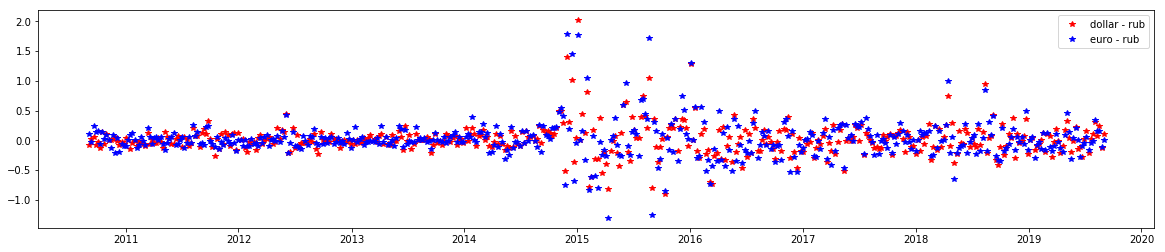

In [162]:
plt.figure(figsize =(20,4))
plt.plot(rub_doll_w.index,rub_doll_w['diff'].values,'*r', label='dollar - rub')
plt.plot(rub_e_w.index,rub_e_w['diff'].values,'*b', label='euro - rub')
plt.legend()


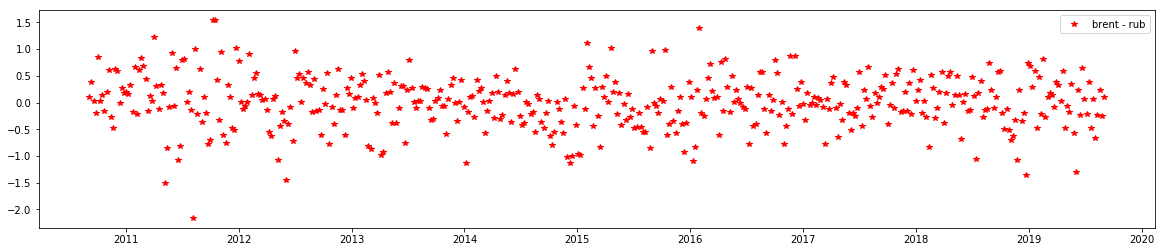

In [163]:
plt.figure(figsize =(20,4))
plt.plot(brent_data_w.index,brent_data_w['diff'].values,'*r', label='brent - rub')
plt.legend()


In [ ]:
# 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [169]:
# Глядя на распределение первой разности от стоимости брента, можно заподозрить её стационарность
# проверим это прдеположение, используя тест Дики-Фуллера и графический анализ от модели ARIMA   
#
adf_test = sm.tsa.stattools.adfuller(brent_data_w['diff'])
print(adf_test[0], adf_test[4])
# DF - test:  показатель много меньше 1% отметки, т.е. ряд похож на стационарный

-6.602486924207591 {'1%': -3.44455286264131, '5%': -2.8678027030003483, '10%': -2.5701057817594894}


In [172]:
import warnings

# Определим p, d и q 
q = p = d = 0
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 26 недель
qs = ps =ds = 0
seasonal_pdq = [ps, ds, qs ,26] 

warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(brent_data_w['diff'].values[:],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[0, 0, 0]x[0, 0, 0, 26] - AIC:653.4210136339606


In [173]:
print(results.summary().tables[0],results.summary().tables[1])

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  470
Model:                        SARIMAX   Log Likelihood                -325.711
Date:                Mon, 03 Feb 2020   AIC                            653.421
Time:                        18:24:51   BIC                            657.572
Sample:                             0   HQIC                           655.054
                                - 470                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2348      0.012     18.966      0.0

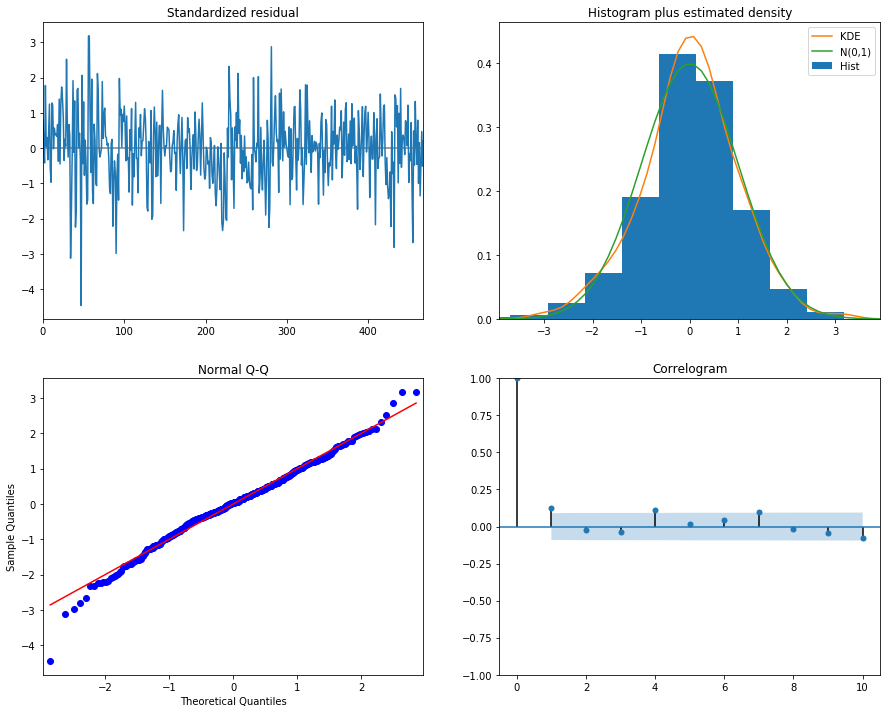

In [175]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [179]:
# таким образом, первая разность ведет себя как стационарный ряд и предсказанием для следующего
# момента следует считать среднее значение этого ряда:
print(brent_data_w['diff'].mean())
brent_data_w['diff'].std()


7.943262411348018e-05


0.48460824522604434

In [ ]:
# 0 (на фоне величины стандартного отклонения)
# Скачок в дисперсии курса валют говорит о точечном характере изменения обстановки (цены рубля)
# без смены "управляющего закона", а отсутствие такого скачка в рублевой стоимости брента  
# говорит о том, что рубль скакнул совместно с нефтью
# Разная величина дисперсии курса валют в начале (2010) и в конце (2020) временного интервала
# говорит о смене масштаба стоимости валюты (больше дисперсия - дороже валюта)
# с сохранением остальных обстоятельств, обуславливающих колебания стоимости нефти в рублях